# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. Challenges might be sampling convergence due to high energy barriers or entropy differences. 


To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Gibbs Free Energy.

$A_x = V_x - T_x  S_x = -\beta ln(Z_x) $



Get to stat therm:

Or we can use the statistical approach:

$G_x = -\frac{1}{\beta}  ln(e^{-\beta H_x})$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta G_{ij} = G_j - G_i = -\beta ln(Z_i/Z_j)$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 

In [1]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

from ensembler.conditions.box_conditions import periodicBoundaryCondition


import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


C:\Users\benja\anaconda3\envs\testBar\lib\site-packages\scipy\__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [2]:
simulation_steps_total_per_approach = 10000
space_range = [-10, 10]
rand=0.1
gamma=100


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.



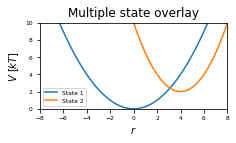

In [3]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 =0.5

entropic_difference = k2 = 1
potential_difference = yoff2 = 2#1
phase_space_distance = xoff2 = 4

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([h1,h2])
fig.tight_layout()
#fig.savefig("2state_systems.png")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ A_x = V_x - T_x  S_x $

For a harmonic Oscillator the entropy term can be formulated as:

$A_x = V_x - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_X \beta}})$



The final free energy difference is:

$\Delta G_{ij} = G_j - G_i$ 


In [4]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  2.17328679514


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated. Afterwards, the trajectories will be evaluated again with the opposite state and afterwards the free energy will be evaluated.

### Sampling
Now we build first the two systems and run the simulations.


{'bodies': [<matplotlib.collections.PolyCollection object at 0x00000209321C4278>]}



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000002093287B3C8>]}


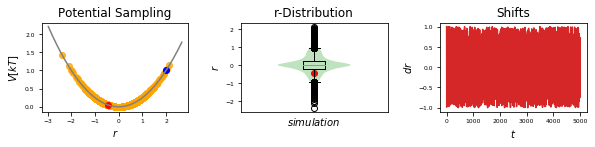

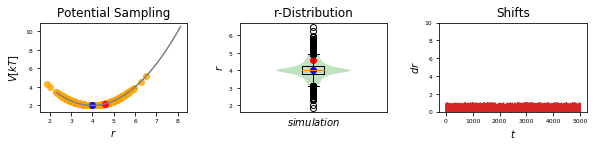

In [5]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
integrator2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, integrator=integrator, position=2)
system2 = system(potential=h2, integrator=integrator2, position=4)

##Simulate:
system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1)

system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()

#visualize
_ = static_sim_plots(system2)
plt.ylim([0,10])
pass

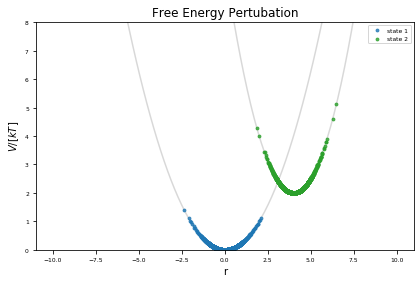

In [6]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="state 1",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="state 2",s=8)
ax[0].set_ylim([0,8])

ax[0].set_xlabel("r")
ax[0].set_xlabel("r")

ax[0].set_ylabel("$V/[kT]$")
#ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Free Energy Pertubation")
#ax[0].set_title("State 2")

fig.savefig("freeEnergyPertubation.png")

### Analysis
#### Zwanzig Equation

In [7]:
V1=state1_traj.totEnergy[equilibration_steps:]
V2=state2_traj.totEnergy[equilibration_steps:]

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  2.17328679514
Zwanzig Result:  2.030529123040274

Difference: -0.1427576721


#### Bennet Acceptance Ratio (BAR)

In [8]:
import pymbar

In [9]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

w_fw = np.array(V21 - V11, dtype=np.float)
w_rv = np.array(V12 - V22, dtype=np.float)

(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
(DeltaF, dDeltaF)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)



Expected Result:  2.17328679514
pymbar - BAR Result:  3.41684775903

Difference: 1.24356096389


In [10]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

state_1 =np.concatenate([V11, V12])
state_2 =np.concatenate([V21, V22])
mbar = pymbar.mbar.MBAR(u_kn=[state_1, state_2], N_k=[len(state_1)/2, len(state_2)/2])
df_mbars, df, _ = mbar.getFreeEnergyDifferences()
print(df_mbars)
df_mbar = np.mean(df_mbars)

overlap, _, _ = mbar.computeOverlap()
print("overlap: ", overlap)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)


[[ 0.          3.41684776]
 [-3.41684776  0.        ]]
overlap:  0.0278603755377

Expected Result:  2.17328679514
pymbar - BAR Result:  3.41684775903

Difference: 1.24356096389


In [11]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iterate: 	convergence raidus: 1e-05
Iteration: 0	dF: 1.871789345833399166897564306 	convergence 1.871789345833399166897564306
Iteration: 1	dF: 1.559371503552489508377186982 	convergence 0.312417842280909658520377324
Iteration: 2	dF: 1.591962543282997353888458141 	convergence 0.032591039730507845511271159
Iteration: 3	dF: 1.588278779543865772287604207 	convergence 0.003683763739131581600853934
Iteration: 4	dF: 1.588691682217778697714490754 	convergence 0.000412902673912925426886547
Iteration: 5	dF: 1.588645357287625308413997670 	convergence 0.000046324930153389300493084
Iteration: 6	dF: 1.588650554084787764192620923 	convergence 0.000005196797162455778623253

Final Iterations:  6  Result:  1.588650554084787764192620923

Expected Result:  2.17328679514
BAR Result:  1.5886505540847877

Difference: -0.584636241055


# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

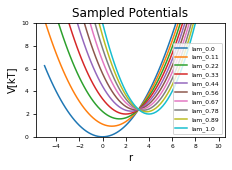

In [12]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [13]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
perturbed_system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lam(lam)
    perturbed_system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

#### Exponential Formula

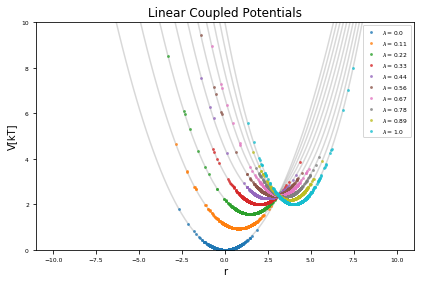

In [14]:
from ensembler import visualisation

#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [0, 10]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))
for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lam(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    
    axes[0].plot(positions,ene, c="grey", zorder=-10,alpha=0.3)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

#axes[1].violinplot(logExp, positions=all_lams, showextrema=False, widths=[0.1 for x in range(len(all_lams))])
#axes[1].boxplot(logExp,  positions=np.round(all_lams, 2), widths=[0.1 for x in range(len(all_lams))])

axes[0].legend()
axes[0].set_ylim(y_range)
axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Linear Coupled Potentials")

#axes[1].set_xlim([-0.2,1.2])
#axes[1].set_ylim([-1,30])

fig.savefig("linear_coupled.png")

### FEP with multiple lambda windows:

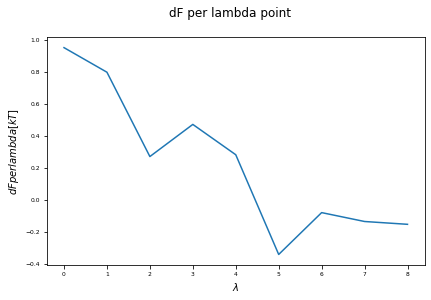


Expected Result:  2.17328679514
trapez Rule Result:  2.08560593279

Difference: -0.0876808623498


(-0.087680862349774458,)

In [15]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.totPotEnergy
    Vj_fw = trajJ.totPotEnergy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

A_fw = np.sum(dA_i_fw)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", A_fw)
print()
print("Difference:", A_fw - dG_expected)


A_fw-dG_expected,

#### Thermodynamic Integration

Text(0.5, 0.98, 'dH/d$\\lambda$ for each Lambda point')

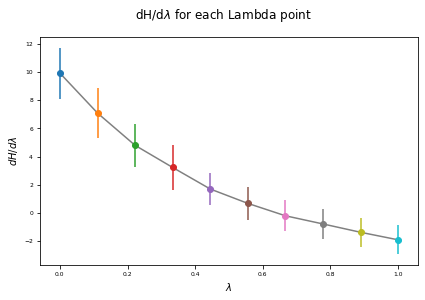

In [16]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dH/d$\lambda$ for each Lambda point")


In [17]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [18]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  2.17328679514
trapez Rule Result:  2.11352220931 +- 1.32872813531

Difference: -0.0597645858264


In [19]:
# or kepschler Weinfass method @gerhard
dF_simpson = integrate.simps(x=lam, y=means)
dF_err = integrate.simps(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_simpson, "+-", dF_err)
print()
print("Difference:", dF_simpson - dG_expected)


Expected Result:  2.17328679514
trapez Rule Result:  2.09215822469 +- 1.32821442961

Difference: -0.0811285704545


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

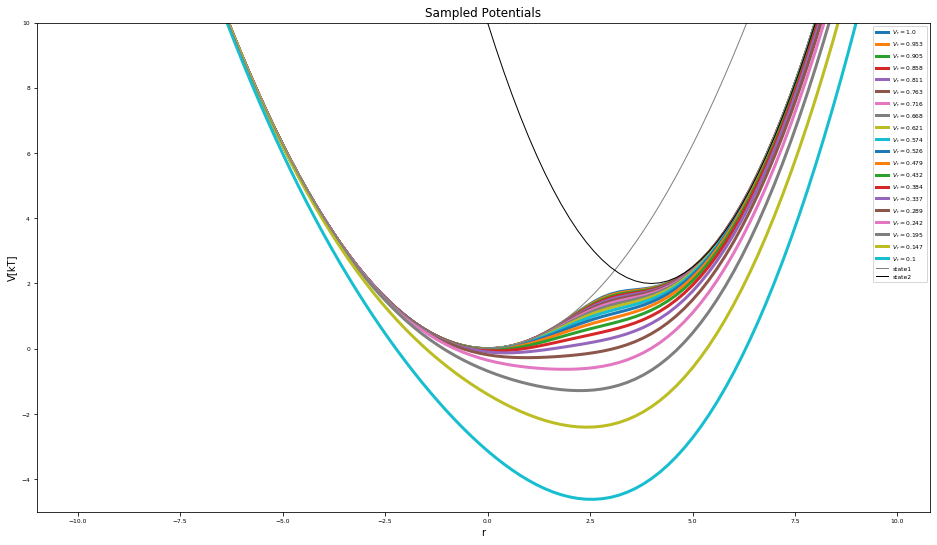

In [20]:
#Build Potential
s=1
Eoff = [0,0]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s)
s_values = np.linspace(1,0.1, 20)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
#plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [ ]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_eds, integrator=integrator, eds_Eoff=Eoff)
eds_simulation_trajs = []

for s in s_values:
    print(s)
    eds_system.set_s(s)
    eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state1_traj = eds_system.getTrajectory()
    eds_simulation_trajs.append(state1_traj)


In [ ]:
#Visualisation
seperateeach=3
rel_max = 5

nTrajs = len(simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(eds_simulation_trajs):
    V_eds.s_i = traj.s[1]
    ene =  V_eds.ene(positions)
    axes[ind].plot(positions, ene, c="C0", )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="orange")
    axes[ind].set_ylim([np.min(ene)-1,np.min(ene)+rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


### FEP-EDS_Evaluation

In [ ]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(eds_simulation_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


### BAR-EDS_Evaluation

In [ ]:
for ind,traj in enumerate(eds_simulation_trajs):
    print("SIMULATION ", ind)
    print("\ts = ", str(round(traj.s[1],3)))
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    w_fw = np.array(V1 - VR, dtype=np.float)
    w_rv = np.array(V2 - VR, dtype=np.float)

    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
    
    print(DeltaF, DeltaF-dG_expected)

In [ ]:
for ind,traj in enumerate(eds_simulation_trajs):
    print("SIMULATION ", ind)
    print("\ts = ", str(round(traj.s[1],3)))
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    mbar = pymbar.mbar.MBAR(u_kn=[V1, V2], N_k=[len(state_1)/2, len(state_2)/2])
    df_mbars, df, _ = mbar.getFreeEnergyDifferences()
    print(df_mbars)
    overlap, _, _ = mbar.computeOverlap()
    print("overlap: ", overlap)
    break
    


# Hybrid Methods - $\lambda-EDS $

In [ ]:
#Build Potential
s=1
V_hleds = pot.hybridCoupledPotentials(Va=h1, Vb=h2, s=1, lam=0.5)

#Build Potential
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[h1,h2] , s=s)
s_values = np.linspace(1,0.1, 10)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [ ]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_hleds, integrator=integrator, eds_Eoff=Eoff)
hleds_simulation_trajs = []

for s in s_values:
    print(s)
    hleds_system.set_s(s)
    hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state_traj = hleds_system.getTrajectory()
    hleds_simulation_trajs.append(state_traj)


In [ ]:
#Visualisation
seperateeach=3
rel_max = 5

nTrajs = len(simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(hleds_simulation_trajs):
    V_eds.s_i = traj.s[1]
    ene =  V_eds.ene(positions)
    axes[ind].plot(positions, ene, c="C0", )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="orange")
    axes[ind].set_ylim([np.min(ene)-1,np.min(ene)+rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


In [ ]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(hleds_simulation_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


# Enhanced Sampling with system Coupling

#### Conveyor Belt TI

In [ ]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

syst = perturbed_system.perturbedSystem(potential=V_perturbed , integrator=integrator)
ens=cvb.ConveyorBelt(0.0, numsys, system=syst, build=False)


In [ ]:
ens.simulate(steps//numsys)


In [ ]:
trajs = ens.get_trajectories()
trajs[0]

In [ ]:
import pandas as pd
trajs = ens.get_trajectories()
mega_traj = pd.concat(list(trajs.values()), ignore_index=True)

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)


fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.totPotEnergy[equilibration_steps:], c="orange")

positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.png")

In [ ]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]
lam_cvb = list(sorted(np.unique(lambda_stat.lam)))
means_cvb = [np.mean(lambda_stat.loc[lambda_stat.lam == x].dhdlam) for x in lam_cvb] 
stds_cvb = [np.std(lambda_stat.loc[lambda_stat.lam == x].dhdlam) for x in lam_cvb] 


In [ ]:
dF_trapez = integrate.trapz(x=lam_cvb, y=means_cvb)
dF_err = integrate.trapz(x=lam_cvb, y=stds_cvb)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)


# RE-EDS

In [ ]:
#potential
Eoff = [0,1.5]
V_eds = pot.envelopedPotential(V_is=[h1,h2])

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=4)
trials=200
steps_between_trials=simulation_steps_total_per_approach//(len(s_values)*trials)

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)
[replica.s for repID, replica in ensemble.replicas.items()]


In [ ]:
ensemble.simulate(trials, reset_ensemble=True)


In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(trajs[traj].totEnergy[eqil:])

    ax.scatter(trajs[traj].position[eqil:], trajs[traj].totEnergy[eqil:])
    ax.set_ylim([min_e-1,min_e+10])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.hist(trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


In [ ]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

In [ ]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [ ]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[0].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

In [ ]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[1].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

In [ ]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 3")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[2].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

In [ ]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 4")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[3].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")